In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression #Logic Regression Model
from sklearn import svm
from sklearn.svm import SVC #SVC
from sklearn.ensemble import RandomForestClassifier #Random Forest Model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import statsmodels.stats.weightstats as st
from scipy.stats import chi2_contingency
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns
import os as os
import csv, sqlite3

## ETL(Data cleaning) 

In [2]:
def clean_data(file_name:str):
    subset_varible=["SEQN","ECD010","ECQ020","ECQ060","ECD070A","MCQ080E","WHQ030E"]  # Filter specified variables
    data=pd.read_csv(file_name)
    data1 = data[subset_varible]
    data1 = data1[data1.ECD010 <= 60] ; data1 = data1[data1.ECQ060 <= 2]
    data1 = data1[data1.ECD070A <= 20] ; data1 = data1[data1.WHQ030E <= 3]
    data1 = data1[data1.MCQ080E <= 2] ; data1 = data1[data1.ECQ020 <= 2]#Remove abnormal data
    data1.MCQ080E[data1['MCQ080E'] == 2] = 0 #Change value 2 to 0 which means overweight
    data1 = data1.dropna() # Remove the empty data in the rows
    data1.columns = ["ID","Mother's age when born", "Mother smoked when pregnant",
                   "Receive newborn care at health facility", "Weight at birth, pounds",
                     "Doctor confirmed overweight", "How do you consider weight"]
    #print(data1.shape) #Check data dimensions
    #data1.head()
    return data1

In [3]:
def ETL(data1:pd.DataFrame):
    conn = sqlite3.connect('database.db')
    try:
        conn.execute('DROP TABLE IF EXISTS `tan2345` ')
    except Exception as e:
        raise(e)
    finally:
        print('Table dropped')
    def create_table():
        conn = sqlite3.connect("database.db")
        try:
            create_tb_cmd='''
           create table tan2345(ID integer,Mother's age when born integer,Mother smoked when pregnant integer,Receive newborn care at health facility integer,How do you consider weight integer,Weight at birth, pounds integer,Doctor confirmed overweight integer);
            '''
            conn.execute(create_tb_cmd)
        except:
            print("Create table failed")
            return False
        #conn.execute(insert_dt_cmd)
        conn.commit()
    create_table()
    conn = sqlite3.connect("database.db")
    cu=conn.cursor()
    #Insert the newly fetched data into the database's table 
    data1.to_sql('tan2345',conn, if_exists='append', index=False)  
    conn.commit()
    ##Read the newest data from the database
    conn = sqlite3.connect("database.db")
    #print(conn)
    sql="SELECT * from tan2345"
    data2=pd.read_sql(sql,conn)
    return data2

In [4]:
file_name = r"C:\Users\laura\Desktop\dissertation\App\appfunction\ECQ_D.csv"
data1 = clean_data(file_name)
data1.head()

,ID,Mother's age when born,Mother smoked when pregnant,Receive newborn care at health facility,"Weight at birth, pounds",Doctor confirmed overweight,How do you consider weight
1,31128.0,33.0,1.0,1.0,4.0,0.0,2.0
2,31129.0,19.0,2.0,2.0,6.0,0.0,3.0
4,31137.0,17.0,2.0,2.0,7.0,0.0,1.0
5,31138.0,21.0,2.0,2.0,7.0,0.0,3.0
6,31140.0,31.0,2.0,2.0,10.0,0.0,3.0


In [5]:
data2 = ETL(data1)
data2.head()

Table dropped
Create table failed


D:\Attracta\Anaconda\Install\lib\site-packages\pandas\core\generic.py:2778: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


,ID,Mother's age when born,Mother smoked when pregnant,Receive newborn care at health facility,"Weight at birth, pounds",Doctor confirmed overweight,How do you consider weight
0,31128.0,33.0,1.0,1.0,4.0,0.0,2.0
1,31129.0,19.0,2.0,2.0,6.0,0.0,3.0
2,31137.0,17.0,2.0,2.0,7.0,0.0,1.0
3,31138.0,21.0,2.0,2.0,7.0,0.0,3.0
4,31140.0,31.0,2.0,2.0,10.0,0.0,3.0


## Statistical Approach 

In [6]:
def Scatter_data(data2:pd.DataFrame, x_name:str, y_name:str):
    l = data2.shape[0]
    x = list(data2[x_name].values + np.random.randint(-500, 500, l) / 1000)
    x_model = [[i] for i in x]
    y = list(data2[y_name].values + np.random.randint(-500, 500, l) / 1000)
    y_model = [[i] for i in y]
    model = linear_model.LinearRegression()
    model.fit(x_model, y_model)
    min_pre = model.predict([[min(x)]])[0][0]
    max_pre = model.predict([[max(x)]])[0][0]
    scatter = {"x":x, "y":y, "trend_lines":[[min(x), max(x)], [min_pre, max_pre]]}
    return scatter

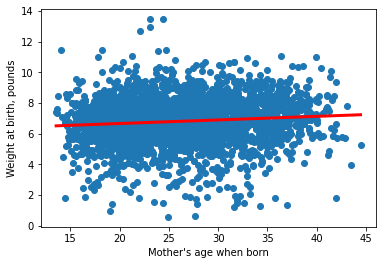

The red line shows the average weight changes with mother's age


In [7]:
x_scatter = "Mother's age when born" ; y_scatter = "Weight at birth, pounds"
scatter = Scatter_data(data2, x_scatter, y_scatter)
plt.scatter(scatter["x"], scatter["y"])
plt.plot(scatter["trend_lines"][0], scatter["trend_lines"][1], 'red', lw = 3)
plt.xlabel(x_scatter)
plt.ylabel(y_scatter)
plt.show()
print("The red line shows the average weight changes with mother's age")

In [8]:
def Correlation_data(data2:pd.DataFrame, variables:list):
    corr = data2[variables].corr(method='kendall')   # Calculate the correlation coefficient of 1 to 3 columns of variables
    return corr

<AxesSubplot:>

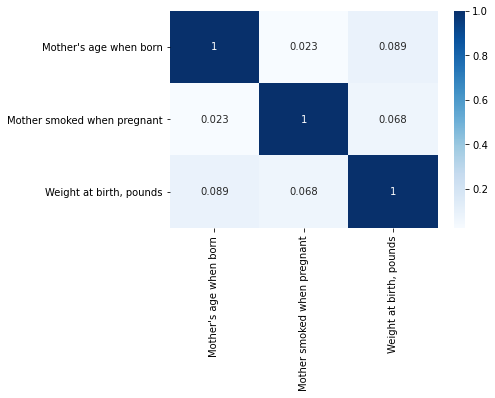

In [9]:
corr_vars2 = ["Mother's age when born",	"Mother smoked when pregnant", "Weight at birth, pounds"]
corr2 = Correlation_data(data2, corr_vars2)
sns.heatmap(corr2, annot = True, cmap = "Blues")

In [10]:
def Kde_data(data2):
    factor_name = 'Mother smoked when pregnant'; x_name = 'Weight at birth, pounds'
    smoke = list(data2[data2[factor_name]==1][x_name]) #Baby weight of smoking mother
    nosmoke = list(data2[data2[factor_name]==2][x_name]) #Baby weight of non-smoking mothers
    
    def get_kde(x,data_array,bandwidth=0.5):
        def gauss(x):
            import math
            return (1/math.sqrt(2*math.pi))*math.exp(-0.5*(x**2))
        N=len(data_array)
        res=0
        if len(data_array)==0:
            return 0
        for i in range(len(data_array)):
            res += gauss((x-data_array[i])/bandwidth)
        res /= (N*bandwidth)
        return res
    
    x_smoke=np.linspace(min(smoke), max(smoke),50)
    y_smoke=[get_kde(x_smoke[i], smoke) for i in range(x_smoke.shape[0])]
    
    x_nosmoke=np.linspace(min(nosmoke), max(nosmoke),50)
    y_nosmoke=[get_kde(x_nosmoke[i], nosmoke) for i in range(x_nosmoke.shape[0])]
    return [x_smoke, y_smoke], [x_nosmoke, y_nosmoke]

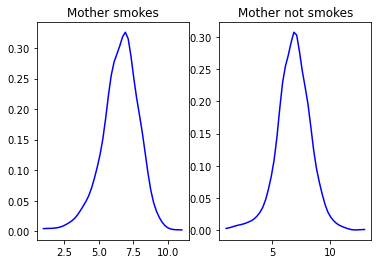

In [11]:
kde_smoke, kde_nosmoke = Kde_data(data2)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(kde_smoke[0], kde_smoke[1], color = 'blue', linestyle = '-')
ax1.set(title='Mother smokes')
ax2.plot(kde_nosmoke[0], kde_nosmoke[1], color = 'blue', linestyle = '-')
ax2.set(title='Mother not smokes')
plt.show()

In [12]:
def Test(data2, x_name, y_name, x_type, y_type, groups, normal = ''):
    #x_type, y_type value is 0(Numerical), 1(Categrical)
    #groups: value is 0( == 2), 1( > 2)
    #normal: optional parameter, value is True(yes),False(no)
    try:
        if x_type + y_type == 1 and groups == 0 and normal == True:
            #If only one variable is Categrical;T-test
            cate = data2[x_name] if len(data2[x_name].value_counts().index) == 2 else data2[y_name]
            cate_types = data2[x_name].value_counts().index
            nums = data2[x_name] if len(data2[x_name].value_counts().index) > 2 else data2[y_name]
            nums0 = nums[cate==cate_types[0]]
            nums1 = nums[cate==cate_types[1]]
            t, p_two, df = st.ttest_ind(nums0, nums1)
            words = 't test result is：' + 't=' + str(t) + ',P value=' + str(p_two) + ',Freedom Degree=' + str(df)
            alpha = 0.05 
            if(p_two < alpha):
                words = words + '\nP<α，Reject the null hypothesis，%s and %s has %s significant difference. ' %\
                (cate.name+str(cate_types[0]), cate.name+str(cate_types[1]), nums.name)
            else: 
                words = words + '\nP>α，Accept the null hypothesis，%s and %s has no %s significant difference. ' %\
                (cate.name+str(cate_types[0]), cate.name+str(cate_types[1]), nums.name)

        elif len(data2[x_name].value_counts().index) < 5 and len(data2[y_name].value_counts().index) < 5:
            #If two variables are Categrical;Chi-test
            table = pd.crosstab(data2[x_name], data2[y_name])
            chi = chi2_contingency(table)
            words = 'Chi-square test result is：' + 'chisq-statistic=' + str(chi[0]) + ',P value=' + str(chi[1]) + ',Freedom Degree=' + str(chi[2])
            alpha = 0.05
            if(chi[1] < alpha):
                words = words + '\nP<α，Reject the null hypothesis，%s and %s has significant difference. ' % (x_name, y_name)
            else: 
                words = words + '\nP>α，Accept the null hypothesis，%s and %s has no significant difference. ' % (x_name, y_name)
        elif x_type + y_type == 1 and groups == 1:
            #If obly one variable is Categrical;Variance test
            cate = data2[x_name] if len(data2[x_name].value_counts().index) <\
            len(data2[y_name].value_counts().index) else data2[y_name]
            nums = data2[x_name] if len(data2[x_name].value_counts().index) >\
            len(data2[y_name].value_counts().index) else data2[y_name]
            aov = []
            for i in cate.value_counts().index:
                aov.append(nums[cate==i])
            aov_test = stats.f_oneway(*aov)
            words = 'The result of the variance test is：' + 'F=' + str(aov_test[0]) + ',P value=' + str(aov_test[1])
            alpha = 0.05
            if(aov_test[1] < alpha):
                words = words + '\nP<α，Reject the null hypothesis，%s and %s has significant difference. ' % (cate.name, nums.name)
            else: 
                words = words + '\nP>α，Accept the null hypothesis，%s and %s has no significant difference.' % (cate.name, nums.name)
        else:
            words = 'Error, please select again'
    except:
        words = 'Error, please select again'
        
    return words

In [13]:
aov_test = Test(data2, 'How do you consider weight', 'Weight at birth, pounds', 1, 0, 1, normal = True) #Variance test
print(aov_test)

The result of the variance test is：F=11.499728825927649,P value=1.056500837798812e-05
P<α，Reject the null hypothesis，How do you consider weight and Weight at birth, pounds has significant difference. 


In [14]:
t_test = Test(data2, 'Mother smoked when pregnant', 'Weight at birth, pounds', 1, 0, 0, normal = True) #T test
print(t_test)

t test result is：t=4.2587208374825645,P value=2.116083306858783e-05,Freedom Degree=3152.0
P<α，Reject the null hypothesis，Mother smoked when pregnant2.0 and Mother smoked when pregnant1.0 has Weight at birth, pounds significant difference. 


In [15]:
chi_test = Test(data2, 'Mother smoked when pregnant', 'Doctor confirmed overweight', 1, 1, 2) #Che-Test
print(chi_test)

Chi-square test result is：chisq-statistic=0.00675872757965601,P value=0.9344785439725614,Freedom Degree=1
P>α，Accept the null hypothesis，Mother smoked when pregnant and Doctor confirmed overweight has no significant difference. 


## Machine Learning Models 

In [16]:
def KMeans_data(data2, variables = ["Mother's age when born", "Mother smoked when pregnant", 
                                    "Receive newborn care at health facility", "Weight at birth, pounds", 
                                    "Doctor confirmed overweight", "How do you consider weight"], k = 5):
    Kdata = data2[variables] #Remove first column
    Kdata = (Kdata - Kdata.mean(axis  =0))/(Kdata.std(axis = 0)) #z-score Strandardize
    kmodel = KMeans(n_clusters = k) #Group 5 categories 
    kmodel.fit(Kdata) #Train Model
    label = pd.Series(kmodel.labels_)  # Types of samples
    Kdata['Type'] = label.values
    return Kdata 

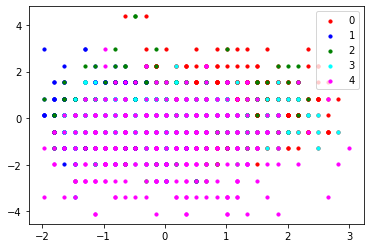

Analysis Results: This shows the data distribution and data can be devided into 5 groups, majority group is type 4.


In [17]:
kmeans = KMeans_data(data2)
kxn = "Mother's age when born"
kyn = "Weight at birth, pounds"
plt.scatter(list(kmeans[kxn][kmeans['Type'] == 0]), list(kmeans[kyn][kmeans['Type'] == 0]), s = 10, c = 'red', label = '0')
plt.scatter(list(kmeans[kxn][kmeans['Type'] == 1]), list(kmeans[kyn][kmeans['Type'] == 1]), s = 10, c = 'blue', label = '1')
plt.scatter(list(kmeans[kxn][kmeans['Type'] == 2]), list(kmeans[kyn][kmeans['Type'] == 2]), s = 10, c = 'green', label = '2')
plt.scatter(list(kmeans[kxn][kmeans['Type'] == 3]), list(kmeans[kyn][kmeans['Type'] == 3]), s = 10, c = 'cyan', label = '3')
plt.scatter(list(kmeans[kxn][kmeans['Type'] == 4]), list(kmeans[kyn][kmeans['Type'] == 4]), s = 10, c = 'magenta', label = '4')
plt.legend()
plt.show()

print("Analysis Results: This shows the data distribution and data can be devided into 5 groups, majority group is type 4.")

In [18]:
def Model_data(data2:pd.DataFrame):
    #No risk factor:ECQ020
    vars1 = ["Mother's age when born", "Receive newborn care at health facility", 
             "Weight at birth, pounds", "How do you consider weight"]
    data1_x = data2[vars1] #Choose X variable
    data1_y = data2["Doctor confirmed overweight"]#Choose Y variable
    train1_x, test1_x, train1_y, test1_y = train_test_split(data1_x, data1_y, train_size = 0.8, random_state = 123)
    #20% Test; 80% Train Set

    #With Risk Factor: ECQ020
    vars2 = ["Mother's age when born", "Mother smoked when pregnant", "Receive newborn care at health facility", 
             "Weight at birth, pounds", "How do you consider weight"]
    data2_x = data2[vars2] #Choose X variable
    data2_y = data2['Doctor confirmed overweight'] #Choose Y variable
    train2_x, test2_x, train2_y, test2_y = train_test_split(data2_x, data2_y, train_size = 0.8, random_state = 123) 
    #20% Test; 80% Train Set
    
    def ModelLogic(train_x : pd.DataFrame, train_y : pd.DataFrame): #LogicRegression
        x = train_x.values ; y = train_y.values
        model = LogisticRegression() #Build LogicRegression Model y = 1 / (1 + exp ** (-x))
        model.fit(x, y) #Train Model
        return model
 
    def ModelSVC(train_x : pd.DataFrame, train_y : pd.DataFrame): #SVC
        x = train_x.values ; y = train_y.values
        model = SVC(C = 2, kernel = 'sigmoid', probability = True) #probability must be True
        model.fit(x, y)
        return model

    def ModelForest(train_x : pd.DataFrame, train_y : pd.DataFrame): #RandomForest
        x = train_x.values ; y = train_y.values
        model = RandomForestClassifier(max_depth = 6, n_estimators = 200, random_state = 5)
        model.fit(x, y)
        return model
    
    def ModelTest(model, test_x, test_y): #Define model checking function
        pred = list(model.predict(test_x)) #Predict test set data
        pd_rl = pd.DataFrame({'pred' : pred, 'true' : test_y.values})
        try:
            TP = pd.crosstab(pd_rl.true, pd_rl.pred)[1][1] #True Positive example: the actual value is 1, the predicted value is also 1
        except:
            TP = 0
        try:
            FP = pd.crosstab(pd_rl.true, pd_rl.pred)[1][0] #False positive example: actual value is 0, predicted value is 1
        except:
            FP = 0
        try:
            TN = pd.crosstab(pd_rl.true, pd_rl.pred)[0][0] #True negative example: the actual value is 0, and the predicted value is also 0
        except:
            TN = 0
        try:
            FN = pd.crosstab(pd_rl.true, pd_rl.pred)[0][1] #False Negative example: the actual value is 1, the predicted value is 0
        except:
            FN = 0
        #Model Accuracy、Precision、Sensitivity、Recall/Specificity、F1 value、cohen's kappa
        test_dict = {}
        #print('Accuracy:'+ accuracy_score(pd_rl.true, pd_rl.pred))
        test_dict.update({'Accuracy' : model.score(test_x, test_y)}) #Model evaluation, accuracy
        try:
            test_dict.update({'Precision' : TP / (TP + FP)}) #Model evaluation, accuracy rate
        except:
            test_dict.update({'Precision' : 0}) #Model evaluation, accuracy rate
        try:
        #Model evaluation, sensitivity = number of true positives TP/(number of true positives TP + number of false negativesFN) * 100%.
        #Correctly judge the rate of patients;
            test_dict.update({'Sensitivity' : TP / (TP + FN)})
        except:
            test_dict.update({'Sensitivity' : 0}) #Model evaluation, recall/sensitivity
        #Specificity = number of true negatives TN/(number of true negatives TN + number of false positives FP))*100%. 
        #Correctly judge the rate of non-patients
        test_dict.update({'Specificity' : TN / (TN + FP)})
        test_dict.update({'F1' : TN / 2 * TP / (2 * TP + FN + FP)}) #Model evaluation, F1 value
        p0 = (TP + TN) / (TP + FP + TN + FN)
        pe = ((TP  + FN) * (TP + FP) + (TN + FP) * (TN + FN)) / (TP + FP + TN + FN) ** 2
        test_dict.update({"cohen's kappa" : (p0 - pe) / (1 - pe)})  #Model evaluation, cohen's kappa coefficient value
        
        return test_dict

    modellog1 = ModelLogic(train1_x, train1_y) #Build a logistic regression model
    modelsvc1 = ModelSVC(train1_x, train1_y) #Build SVC Model1
    modelforest1 = ModelForest(train1_x, train1_y) #Build a random forest model1
    log1 = ModelTest(modellog1, test1_x, test1_y)
    svc1 = ModelTest(modelsvc1, test1_x, test1_y)
    forest1 = ModelTest(modelforest1, test1_x, test1_y)
    
    modellog2 = ModelLogic(train2_x, train2_y) #Build a logistic regression model
    modelsvc2 = ModelSVC(train2_x, train2_y) #Build SVC Model1
    modelforest2 = ModelForest(train2_x, train2_y) #Build a random forest model1
    log2=ModelTest(modellog2, test2_x, test2_y)
    svc2 = ModelTest(modelsvc2, test2_x, test2_y)
    forest2 = ModelTest(modelforest2, test2_x, test2_y)
    
    # predict probabilities
    #pred_prob0 = modellinear1.predict_proba(test1_x)
    pred_prob1 = modellog1.predict_proba(test1_x)
    pred_prob2 = modelsvc1.predict_proba(test1_x)
    pred_prob3 = modelforest1.predict_proba(test1_x)

    pred_prob4 = modellog2.predict_proba(test2_x)
    pred_prob5 = modelsvc2.predict_proba(test2_x)
    pred_prob6 = modelforest2.predict_proba(test2_x)
    #pred_prob7 = modellinear2.predict_proba(test2_x)
    # roc curve for models
    #fpr0, tpr0, thresh0 = roc_curve(test1_y, pred_prob1[:,1], pos_label=1)
    fpr1, tpr1, thresh1 = roc_curve(test1_y, pred_prob1[:,1], pos_label=1)
    fpr2, tpr2, thresh2 = roc_curve(test1_y, pred_prob2[:,1], pos_label=1)
    fpr3, tpr3, thresh3 = roc_curve(test1_y, pred_prob3[:,1], pos_label=1)
    fpr4, tpr4, thresh4 = roc_curve(test2_y, pred_prob4[:,1], pos_label=1)
    fpr5, tpr5, thresh5 = roc_curve(test2_y, pred_prob5[:,1], pos_label=1)
    fpr6, tpr6, thresh6 = roc_curve(test2_y, pred_prob6[:,1], pos_label=1)
    #fpr7, tpr7, thresh7 = roc_curve(test2_y, pred_prob7[:,1], pos_label=1)
    # auc scores
    #auc_score0 = roc_auc_score(test0_y, pred_prob0[:,1])
    auc_score1 = roc_auc_score(test1_y, pred_prob1[:,1])
    auc_score2 = roc_auc_score(test1_y, pred_prob2[:,1])
    auc_score3 = roc_auc_score(test1_y, pred_prob3[:,1])
    auc_score4 = roc_auc_score(test2_y, pred_prob4[:,1])
    auc_score5 = roc_auc_score(test2_y, pred_prob5[:,1])
    auc_score6 = roc_auc_score(test2_y, pred_prob6[:,1])
    #auc_score7 = roc_auc_score(test2_y, pred_prob7[:,1])
    Roc_data = {"log_no":[fpr1, tpr1, auc_score1], "rft_no":[fpr2, tpr2, auc_score2], "svc_no":[fpr3, tpr3, auc_score3],
               "log":[fpr4, tpr4, auc_score4], "rft":[fpr5, tpr5, auc_score5], "svc":[fpr6, tpr6, auc_score6]}
    test_dict = {i:[log1[i], log2[i], svc1[i], svc2[i], forest1[i], forest2[i]] for i in log1.keys()}
    test_df = pd.DataFrame.from_dict(test_dict, orient = 'index')
    test_df.columns = [' LogicRisk', ' LogicNoRisk', ' SVCRisk', ' SVCNoRisk', ' ForestRisk', ' ForestNoRisk']
    
    Roc_labels = {'log_no':['LogicRegression(No Risk) (area = %0.2f)' % auc_score1, auc_score1]}
    Roc_labels.update({'rft_no':['RandomForest(No Risk) (area = %0.2f)' % auc_score2, auc_score2]})
    Roc_labels.update({'svc_no':['SVC(No Risk) (area = %0.2f)' % auc_score3, auc_score3]})
    Roc_labels.update({'log':['LogicRegression(Risk) (area = %0.2f)' % auc_score4, auc_score4]})
    Roc_labels.update({'rft':['RandomForest(Risk) (area = %0.2f)' % auc_score5, auc_score5]})
    Roc_labels.update({'svc':['SVC(Risk) (area = %0.2f)' % auc_score6, auc_score6]})
    return Roc_data, Roc_labels, test_df

In [19]:
roc, roc_labels, test_df = Model_data(data2)

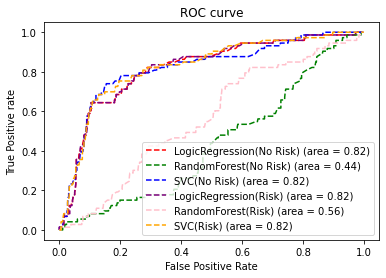

Recommendation model : SVC(Risk) (area = 0.82)


In [20]:
#plt.style.use('seaborn')
# plot roc curves
#plt.plot([0, 1], [0, 1], color = 'black', lw = 1, linestyle = '--')

plt.plot(roc["log_no"][0], roc["log_no"][1], linestyle='--',color='red', label = roc_labels["log_no"][0])
plt.plot(roc["rft_no"][0], roc["rft_no"][1], linestyle='--',color='green', label = roc_labels["rft_no"][0])
plt.plot(roc["svc_no"][0], roc["svc_no"][1], linestyle='--',color='blue', label = roc_labels["svc_no"][0])
plt.plot(roc["log"][0], roc["log"][1], linestyle='--',color='purple', label = roc_labels["log"][0])
plt.plot(roc["rft"][0], roc["rft"][1], linestyle='--',color='pink', label = roc_labels["rft"][0])
plt.plot(roc["svc"][0], roc["svc"][1], linestyle='--',color='orange', label = roc_labels["svc"][0])

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

max_roc = max([i[1] for i in roc_labels.values()])
idx = [i[1] for i in roc_labels.values()].index(max_roc)
roc_name = [i[0] for i in roc_labels.values()][idx]
print("Recommendation model : " + roc_name)

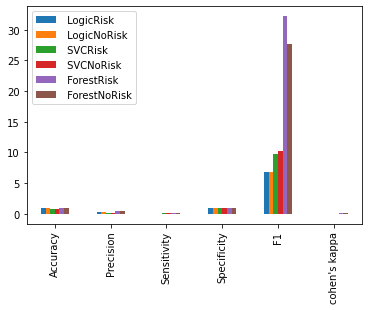

This figure shows all the machine learning parameters in comparison


In [21]:
test_df.plot(kind='bar', stacked=False)
plt.show()
print("This figure shows all the machine learning parameters in comparison")

## Compare average 

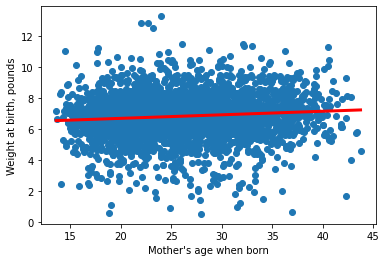

The red line shows the average weight changes with mother's age


In [22]:
x_scatter = "Mother's age when born" ; y_scatter = "Weight at birth, pounds"
scatter = Scatter_data(data2, x_scatter, y_scatter)
plt.scatter(scatter["x"], scatter["y"])
plt.plot(scatter["trend_lines"][0], scatter["trend_lines"][1], 'red', lw = 3)
plt.xlabel(x_scatter)
plt.ylabel(y_scatter)
plt.show()
print("The red line shows the average weight changes with mother's age")

In [23]:
def Line_data(data2:pd.DataFrame, x_name:str, y_name:str):
    count_mean = data2.mean()[y_name]  # Calculate the overall average value 
    # Calculate the mean of different age groups
    mean_result = data2.groupby(x_name).mean()[y_name]
    x_data = [str(int(i)) for i in mean_result.index]  
    y_data = mean_result.values
    line = {"x":x_data, "y":y_data, "count_mean":count_mean}
    return line

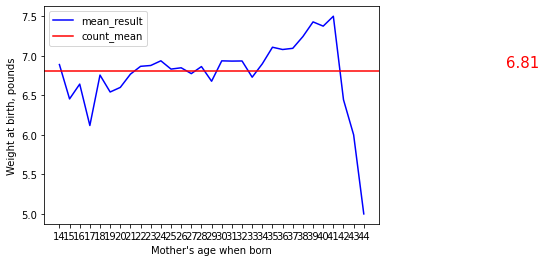

In [24]:
x_line = "Mother's age when born"
y_line = "Weight at birth, pounds"
line = Line_data(data2, x_line, y_line)
plt.plot(line["x"], line["y"], color = 'b', label = 'mean_result') #Line Chart
plt.axhline(y = line["count_mean"], color = 'r', label = 'count_mean') #Add the average line
plt.text(44, 6.85, round(line["count_mean"], 2), fontdict = {'size' : '15','color' : 'r'}) #Add Label
plt.legend() 
plt.ylabel(y_line) ; plt.xlabel(x_line) #Add label for x, y axis
plt.show()

In [31]:
def Describe_data(data2, factor_name = 'Mother smoked when pregnant', x_name = 'Weight at birth, pounds'):
    smoke = data2[data2[factor_name]==1][x_name] #Baby weight of smoking mother
    nosmoke = data2[data2[factor_name]==2][x_name] #Baby weight of non-smoking mother
    des = pd.concat([smoke.describe(), nosmoke.describe()],axis=1)
    des.columns=['Mother smoked when preganent','Mother not smoke when preganent']
    return des

In [32]:
des_data = Describe_data(data2)
des_data

,Mother smoked when preganent,Mother not smoke when preganent
count,429.000000,2725.000000
mean,6.540793,6.852844
std,1.311823,1.425588
min,1.000000,1.000000
25%,6.000000,6.000000
50%,7.000000,7.000000
75%,7.000000,8.000000
max,11.000000,13.000000


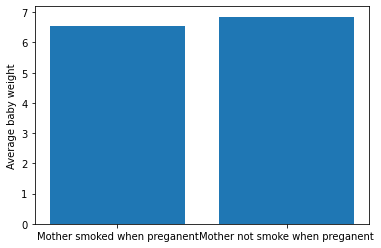

In [36]:
plt.bar(des_data.columns, des_data.loc["mean"])
plt.ylabel("Average baby weight")
plt.show()

## Select Graphics 

In [37]:
def Pie_data(data2:pd.DataFrame, x_name:str):
    numbers = list(data2[x_name].value_counts()) #Get data from column ECQ020 
    names = list(data2[x_name].value_counts().index) #Get the values of column ECQ020
    pie = {"numbers":numbers, "names":names}
    return pie

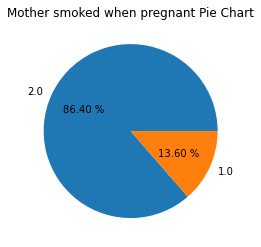

In [38]:
x_pie = "Mother smoked when pregnant"
pie = Pie_data(data2, x_pie)

plt.axes(aspect = 1) #饼图类型
plt.pie(x = pie["numbers"], labels = pie["names"], autopct = '%3.2f %%') #饼图
plt.title(x_pie + ' Pie Chart') #设置标题
plt.show()

In [39]:
def Hist_data(data2:pd.DataFrame, x_name:str):
    hist = list(data2[x_name])
    return hist

Text(0, 0.5, 'Frequency')

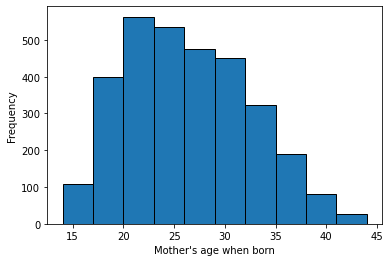

In [40]:
x_hist = "Mother's age when born"
hist = Hist_data(data2, x_hist)

plt.hist(hist, edgecolor = 'k')
plt.xlabel(x_hist)
plt.ylabel("Frequency")

In [41]:
def Box_data(data2:pd.DataFrame, factor_name: str, x_name:str):
    factor = data2[factor_name].value_counts().index
    box = {}
    for i in factor:
        box.update({i : list(data2[data2[factor_name] == i][x_name])})
    return box

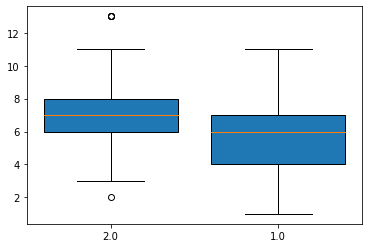

In [42]:
box = Box_data(data2, "Receive newborn care at health facility", "Weight at birth, pounds")
plt.boxplot(box.values(),labels = box.keys(), patch_artist = True, widths = 0.8)
plt.show()

<AxesSubplot:>

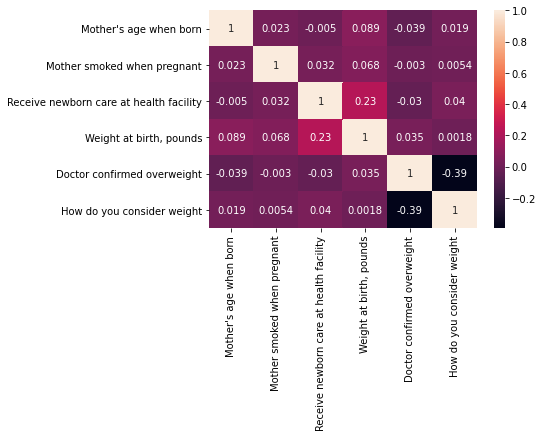

In [43]:
corr_vars1 = ["Mother's age when born", "Mother smoked when pregnant", "Receive newborn care at health facility", 
             "Weight at birth, pounds", "Doctor confirmed overweight", "How do you consider weight"]
corr1 = Correlation_data(data2, corr_vars1)
sns.heatmap(corr1, annot = True)